<a href="https://colab.research.google.com/github/Charles-Scott-Green/Crowdfunding-revenue-prediction/blob/master/GradientBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import libraries
import glob, os 
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
sns.set()

import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

from xgboost import XGBRegressor

import scipy.stats as stats
from scipy.stats.mstats import winsorize

import warnings

In [0]:
def model_scorer(y_test, y_predict, model_name='Model', metric=[]):
    """Given prediction (y_predict) and dependent variable (y_test) data,
    function returns calculated MAE, MSE, RMSE, and/or MAPE scores. Inputs:
    y_test - test data from dataset
    y_predict - model predictions of X_test data (should be shame shape as y_test)
    model_name - string input identifying the model; default is 'Model'
    metric - a list input specifying the desired metric or combination of metrics
             to calculate.  Will accept 'mae', 'mse', 'rmse', 'mape'; default
             is empty list that returns all calculations."""
    
    from statsmodels.tools.eval_measures import mse, rmse  
    from sklearn.metrics import mean_absolute_error
    
    error = y_test - y_predict
    
    a = mean_absolute_error(y_test, y_predict)
    b = mse(y_test, y_predict)
    c = rmse(y_test, y_predict)
    d = np.mean(np.abs(error)/(y_test)*100)
    
    metric_dict = {'mae':a, 'mse':b, 'rmse':c, 'mape':d}
    label_dict = {'mae':'Mean Absolute Error', 
                  'mse':'Mean Squared Error', 
                  'rmse':'Root Mean Squared Error', 
                  'mape':'Mean Absolute Percentage Error'}
    
    if len(metric)<1:
        print(f'------- {model_name} Model Eval. -------')
        print(f'Mean Absolute Error: {a}')
        print(f'Mean Squared Error:{b}')
        print(f'Root Mean Squared Error: {c}')
        print(f'Mean Absolute Percentage Error: {d}') 
    else:
        print(f'------- {model_name} Model Eval. -------')
        for m in metric:
            print(f'{label_dict[m]}:  {metric_dict[m]}')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 21 - Supervised Learning Capstone/data/clean_ks_data_3b.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,backers_count,static_usd_rate,usd_goal,created_to_launch_elapsed,created_to_deadline_elapsed,launch_to_deadline_elapsed,blurb_syllables,blurb_words,name_syllables,name_words,subcat_food trucks,subcat_art,subcat_country & folk,subcat_drinks,pcat_design,pcat_journalism,subcat_drama,subcat_pop,subcat_illustration,subcat_art books,subcat_public art,subcat_restaurants,subcat_animation,ES,...,pcat_food,GB,US,pcat_technology,pcat_games,launched_at_Year,deadline_Year,subcat_tabletop games,launched_at_Week,deadline_Week,created_at_Week,subcat_product design,created_at_Year,launched_at_Dayofweek,deadline_Dayofweek,created_at_Dayofweek,staff_pick,launched_at_Day,deadline_Day,launched_at_Dayofyear,deadline_Dayofyear,created_at_Day,created_at_Dayofyear,spotlight,winsorized_pledge
0,0,1.386294,1.000000,6.908755,1.791759,3.583519,3.433987,35,24,14,9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,2014,2014,False,37,41,36,False,2014,2,4,3,False,10,10,253,283,4,247,False,4.795791
1,1,8.491055,0.729370,8.894904,3.178054,4.094345,3.610918,37,23,11,6,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,2015,2016,False,51,3,47,True,2015,2,3,6,False,16,21,350,21,22,326,True,10.762054
2,2,1.609438,1.000000,8.517393,1.791759,3.583519,3.433987,24,20,3,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,2016,2016,False,2,6,1,True,2016,3,5,4,False,14,13,14,44,8,8,False,4.919981
3,3,0.693147,1.000000,8.699681,1.609438,3.555348,3.433987,37,19,13,6,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,2016,2016,False,4,8,3,True,2016,0,2,3,False,25,24,25,55,21,21,False,3.931826
4,4,4.430817,0.702724,6.961378,2.079442,3.637586,3.433987,22,17,14,9,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,2016,2016,False,2,6,1,True,2016,3,5,3,False,14,13,14,44,7,7,False,7.921164


In [0]:
X = df.drop(columns=['winsorized_pledge', 'Unnamed: 0'], axis=1)
y = df['winsorized_pledge']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, 
                                                    random_state=42)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
predict = model.predict(X_test)

model_scorer(np.expm1(y_test), np.expm1(predict), 'XGB Reg', ['rmse'])

------- XGB Reg Model Eval. -------
Root Mean Squared Error:  3654.5394728901288


In [0]:
# Sample dataframe for tuning
sampled = df.sample(n=15000, replace=True, random_state=42)

sampled.describe()

,Unnamed: 0,backers_count,static_usd_rate,usd_goal,created_to_launch_elapsed,created_to_deadline_elapsed,launch_to_deadline_elapsed,blurb_syllables,blurb_words,name_syllables,name_words,launched_at_Month,deadline_Month,created_at_Month,launched_at_Year,deadline_Year,launched_at_Week,deadline_Week,created_at_Week,created_at_Year,launched_at_Dayofweek,deadline_Dayofweek,created_at_Dayofweek,launched_at_Day,deadline_Day,launched_at_Dayofyear,deadline_Dayofyear,created_at_Day,created_at_Dayofyear,winsorized_pledge
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,117995.894000,3.332854,1.009143,8.280667,2.564997,4.036292,3.465934,30.236333,18.746267,9.733200,5.805333,6.334200,6.671533,6.223467,2015.212667,2015.275467,25.763067,27.159333,25.280467,2015.085867,2.388333,3.149200,2.691133,15.174000,15.220267,176.770067,187.069267,15.387200,173.623000,6.923978
std,68156.093408,1.660581,0.218114,1.166418,1.620314,0.732638,0.356347,7.752622,5.150021,4.491269,2.721482,3.306222,3.301187,3.347219,2.525153,2.515897,14.381226,14.416974,14.591326,2.520208,1.789454,1.954071,1.938724,8.913725,9.136016,100.718009,100.921020,8.810973,102.188111,2.488156
min,28.000000,0.693147,0.008782,5.557085,0.000000,1.386294,0.693147,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2009.000000,2009.000000,1.000000,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.403525
25%,58777.750000,1.945910,1.000000,7.432256,1.386294,3.555348,3.401197,27.000000,16.000000,6.000000,4.000000,4.000000,4.000000,3.000000,2013.000000,2013.000000,14.000000,15.000000,13.000000,2013.000000,1.000000,2.000000,1.000000,7.000000,7.000000,91.000000,101.000000,8.000000,85.000000,5.525453
50%,118420.000000,3.401197,1.000000,8.420072,2.564949,3.891820,3.433987,32.000000,20.000000,10.000000,6.000000,6.000000,7.000000,6.000000,2015.000000,2015.000000,26.000000,27.000000,25.000000,2015.000000,2.000000,3.000000,3.000000,15.000000,15.000000,175.000000,187.000000,15.000000,171.000000,7.449140
75%,176601.000000,4.454347,1.000000,9.210440,3.669891,4.330733,3.583519,36.000000,22.000000,13.000000,8.000000,9.000000,9.000000,9.000000,2017.000000,2017.000000,38.000000,40.000000,38.000000,2017.000000,4.000000,5.000000,4.000000,23.000000,23.000000,263.000000,274.000000,23.000000,260.000000,8.715060
max,235747.000000,10.148236,1.715913,10.308986,7.853605,7.867489,4.521789,50.000000,32.000000,27.000000,20.000000,12.000000,12.000000,12.000000,2019.000000,2019.000000,53.000000,53.000000,53.000000,2019.000000,6.000000,6.000000,6.000000,31.000000,31.000000,366.000000,366.000000,31.000000,366.000000,10.762054


In [0]:
df.describe()

,Unnamed: 0,backers_count,static_usd_rate,usd_goal,created_to_launch_elapsed,created_to_deadline_elapsed,launch_to_deadline_elapsed,blurb_syllables,blurb_words,name_syllables,name_words,launched_at_Month,deadline_Month,created_at_Month,launched_at_Year,deadline_Year,launched_at_Week,deadline_Week,created_at_Week,created_at_Year,launched_at_Dayofweek,deadline_Dayofweek,created_at_Dayofweek,launched_at_Day,deadline_Day,launched_at_Dayofyear,deadline_Dayofyear,created_at_Day,created_at_Dayofyear,winsorized_pledge
count,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000,235750.000000
mean,117874.500000,3.345464,1.008878,8.288524,2.561543,4.034863,3.470193,30.261251,18.749913,9.783580,5.818138,6.345531,6.688454,6.227253,2015.216691,2015.279317,25.815983,27.262401,25.306227,2015.094057,2.381510,3.167177,2.666880,15.147313,15.281060,177.095474,187.637166,15.570918,173.927016,6.947840
std,68055.307318,1.663063,0.215704,1.170947,1.607527,0.721786,0.359134,7.719996,5.139320,4.505589,2.728613,3.315004,3.310877,3.353658,2.512469,2.502907,14.412106,14.450212,14.599770,2.508841,1.784423,1.939263,1.926166,8.873894,9.100909,100.919645,101.206334,8.820926,102.259801,2.480219
min,0.000000,0.693147,0.008771,5.552960,0.000000,0.693147,0.693147,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2009.000000,2009.000000,1.000000,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.375936
25%,58937.250000,1.945910,1.000000,7.467942,1.386294,3.555348,3.401197,27.000000,16.000000,6.000000,4.000000,3.000000,4.000000,3.000000,2013.000000,2013.000000,13.000000,15.000000,13.000000,2013.000000,1.000000,2.000000,1.000000,7.000000,7.000000,90.000000,101.000000,8.000000,85.000000,5.513429
50%,117874.500000,3.433987,1.000000,8.466110,2.564949,3.891820,3.433987,33.000000,20.000000,10.000000,6.000000,6.000000,7.000000,6.000000,2015.000000,2015.000000,26.000000,27.000000,25.000000,2015.000000,2.000000,3.000000,3.000000,15.000000,15.000000,176.000000,187.000000,15.000000,172.000000,7.476472
75%,176811.750000,4.499810,1.000000,9.210440,3.663562,4.330733,3.583519,36.000000,22.000000,13.000000,8.000000,9.000000,10.000000,9.000000,2017.000000,2017.000000,38.000000,40.000000,38.000000,2017.000000,4.000000,5.000000,4.000000,23.000000,23.000000,264.000000,275.000000,23.000000,261.000000,8.748464
max,235749.000000,12.298574,1.716408,10.308986,8.068090,8.077447,4.584967,51.000000,35.000000,29.000000,29.000000,12.000000,12.000000,12.000000,2019.000000,2019.000000,53.000000,53.000000,53.000000,2019.000000,6.000000,6.000000,6.000000,31.000000,31.000000,366.000000,366.000000,31.000000,366.000000,10.762054


In [0]:
X2 = sampled.drop(columns=['Unnamed: 0', 'winsorized_pledge'])
y2 = sampled['winsorized_pledge']

X2_trn, X2_tst, y2_trn, y2_tst = train_test_split(X2, y2, test_size=.20, random_state=42)

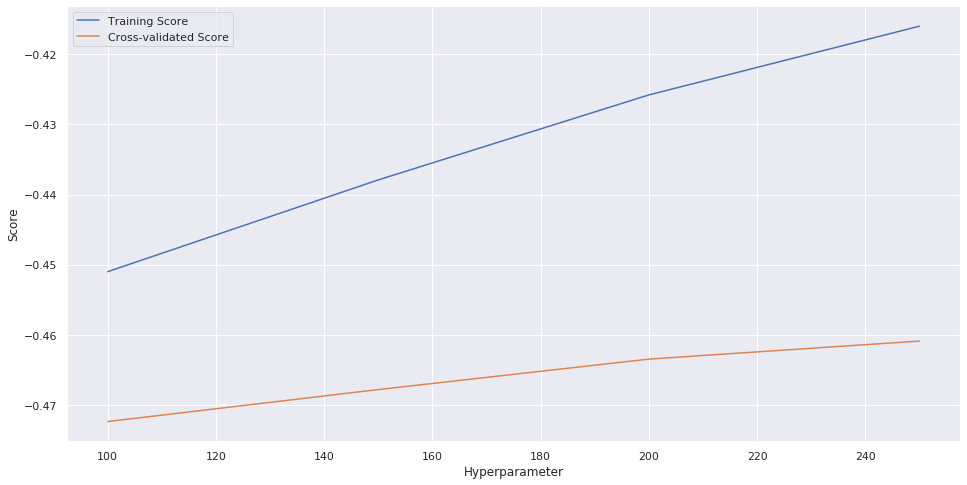

In [0]:
n_est = [100, 150, 200, 250]

nscr, tscr = validation_curve(GradientBoostingRegressor(), X=X2_trn, y=y2_trn, 
                              param_name = 'n_estimators', param_range = n_est, 
                              cv = 5, scoring='neg_mean_absolute_error')

plt.figure(figsize=(16, 8))
plt.plot(n_est, np.mean(nscr, 1), label='Training Score')
plt.plot(n_est, np.mean(tscr, 1), label='Cross-validated Score')
plt.xlabel('Hyperparameter')
plt.ylabel('Score')

plt.legend()
plt.show()

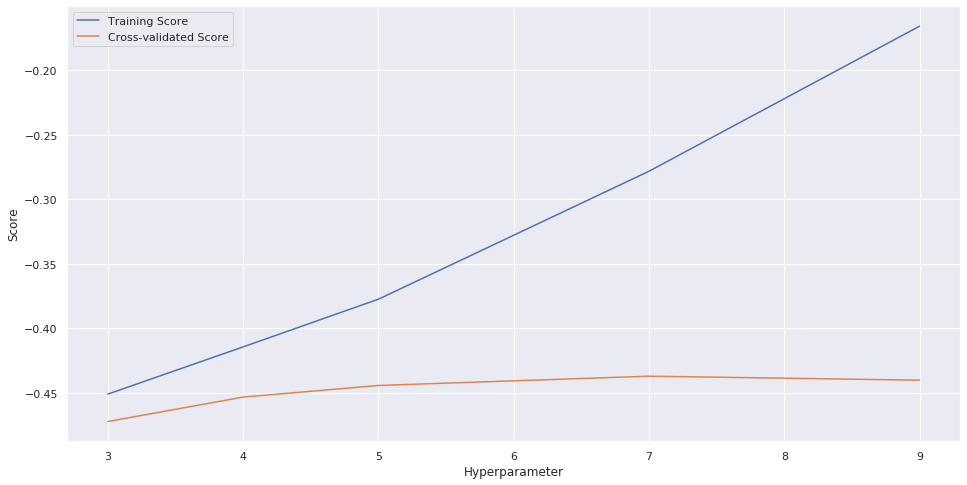

In [0]:
m_dep = [3, 4, 5, 7, 9]

nscr, tscr = validation_curve(GradientBoostingRegressor(), X=X2_trn, y=y2_trn, 
                              param_name = 'max_depth', param_range = m_dep, 
                              cv = 5, scoring='neg_mean_absolute_error')

plt.figure(figsize=(16, 8))
plt.plot(m_dep, np.mean(nscr, 1), label='Training Score')
plt.plot(m_dep, np.mean(tscr, 1), label='Cross-validated Score')
plt.xlabel('Hyperparameter')
plt.ylabel('Score')

plt.legend()
plt.show()

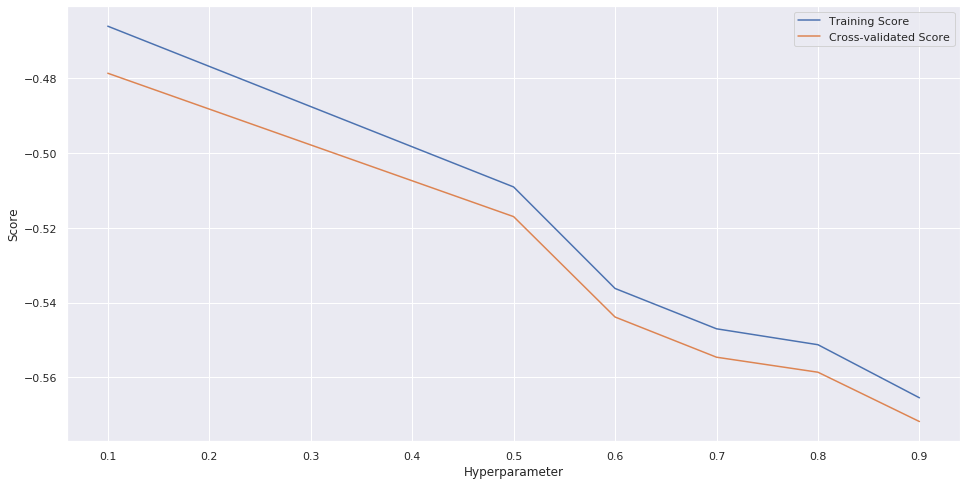

In [0]:
m_ssp = [.1, .5, .6, .7, .8, .9]

nscr, tscr = validation_curve(GradientBoostingRegressor(), X=X2_trn, y=y2_trn, 
                              param_name = 'min_samples_split', param_range = m_ssp, 
                              cv = 5, scoring='neg_mean_absolute_error')

plt.figure(figsize=(16, 8))
plt.plot(m_ssp, np.mean(nscr, 1), label='Training Score')
plt.plot(m_ssp, np.mean(tscr, 1), label='Cross-validated Score')
plt.xlabel('Hyperparameter')
plt.ylabel('Score')

plt.legend()
plt.show()

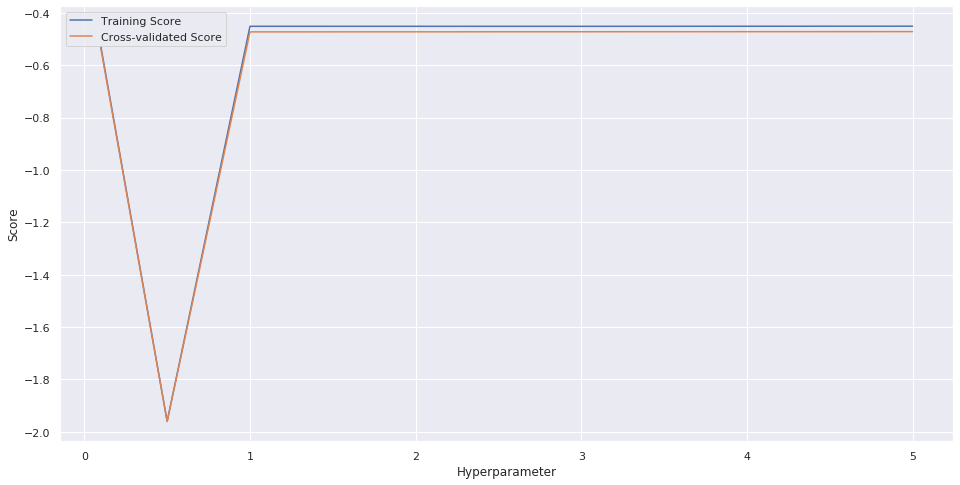

In [0]:
m_sle = [.1, .5, 1, 3, 5]

nscr, tscr = validation_curve(GradientBoostingRegressor(), X=X2_trn, y=y2_trn, 
                              param_name = 'min_samples_leaf', param_range = m_sle, 
                              cv = 5, scoring='neg_mean_absolute_error')

plt.figure(figsize=(16, 8))
plt.plot(m_sle, np.mean(nscr, 1), label='Training Score')
plt.plot(m_sle, np.mean(tscr, 1), label='Cross-validated Score')
plt.xlabel('Hyperparameter')
plt.ylabel('Score')

plt.legend()
plt.show()

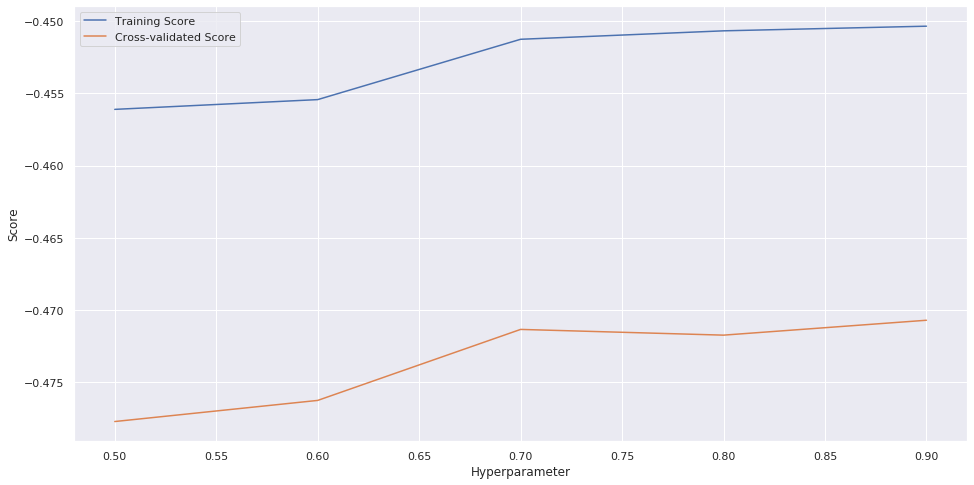

In [0]:
m_fea = [0.5, 0.6, 0.7, 0.8, 0.9]

nscr, tscr = validation_curve(GradientBoostingRegressor(), X=X2_trn, y=y2_trn, 
                              param_name = 'max_features', param_range = m_fea, 
                              cv = 5, scoring='neg_mean_absolute_error')

plt.figure(figsize=(16, 8))
plt.plot(m_fea, np.mean(nscr, 1), label='Training Score')
plt.plot(m_fea, np.mean(tscr, 1), label='Cross-validated Score')
plt.xlabel('Hyperparameter')
plt.ylabel('Score')

plt.legend()
plt.show()

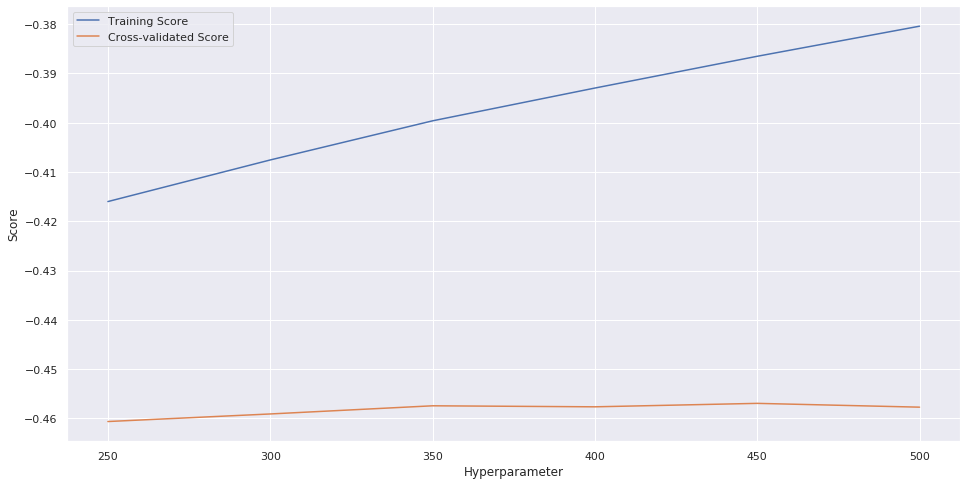

In [0]:
n_est = [250, 300, 350, 400, 450, 500]

nscr, tscr = validation_curve(GradientBoostingRegressor(), X=X2_trn, y=y2_trn, 
                              param_name = 'n_estimators', param_range = n_est, 
                              cv = 5, scoring='neg_mean_absolute_error')

plt.figure(figsize=(16, 8))
plt.plot(n_est, np.mean(nscr, 1), label='Training Score')
plt.plot(n_est, np.mean(tscr, 1), label='Cross-validated Score')
plt.xlabel('Hyperparameter')
plt.ylabel('Score')

plt.legend()
plt.show()

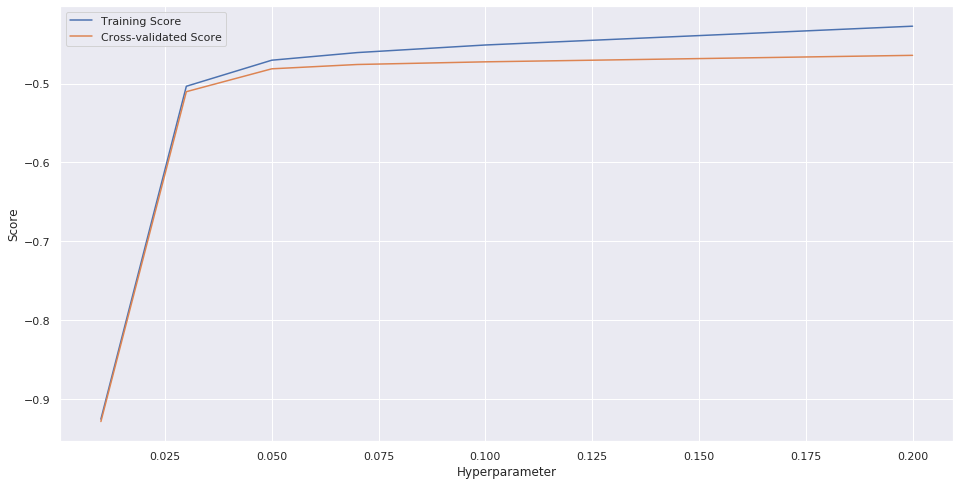

In [0]:
l_rte = [.01, .03, .05, .07, .1, .2]

nscr, tscr = validation_curve(GradientBoostingRegressor(), X=X2_trn, y=y2_trn, 
                              param_name = 'learning_rate', param_range = l_rte, 
                              cv = 5, scoring='neg_mean_absolute_error')

plt.figure(figsize=(16, 8))
plt.plot(l_rte, np.mean(nscr, 1), label='Training Score')
plt.plot(l_rte, np.mean(tscr, 1), label='Cross-validated Score')
plt.xlabel('Hyperparameter')
plt.ylabel('Score')

plt.legend()
plt.show()

Based on the validation curves:
* n_estimators = 350
* max_depth = 7
* min_samples_split = 0.1
* min_samples_leaf = 1
* max_features = 0.9
* learning_rate = 0.05

In [0]:
model = GradientBoostingRegressor(n_estimators=350, max_depth=7, 
                                  min_samples_split=0.1, min_samples_leaf=1,
                                  max_features=0.9, learning_rate=0.05)

model.fit(X_train, y_train)

predict = model.predict(X_test)

cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', 
                cv=5)

array([-0.42532093, -0.41735181, -0.42086144, -0.42796059, -0.42578291])

In [0]:
model_scorer(y_test, predict, 'Gradient Boosting', ['mae'])

------- Gradient Boosting Model Eval. -------
Mean Absolute Error:  0.4238917657075242
